# <center>Sylvester Flow [1]</center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

import sklearn.datasets as datasets

from NF_base import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

**Sylverster Flows**
\begin{equation*}
    z'=z+Ah(Bz+b)
\end{equation*}
with h a piecewise non linearity (e.g. tanh), $A\in\mathbb{R}^{D\times M}$, $B\in\mathbb{R}^{M\times D}$, $b\in\mathbb{R}^M$.

The Jacobian is then:
\begin{align*}
    J_T(z) = I+A\mathrm{diag}(h'(Bz+b))B
\end{align*}
Then, the determinant of the Jacobian is:
\begin{align*}
    \det J_T(z) &= \det(I_D+A\mathrm{diag}(h'(Bz+b)B) \\
    &= \det(I_M+\mathrm{diag}(h'(Bz+b)BA) \text{ by the Sylvester's determinant identity: }\det(I_D+AB)=\det(I_M+BA)
\end{align*}


Problem: not always invertible

Thus propose to take: $A=QR$ and $B=\tilde{R}Q$ with $R, \tilde{R}\in\mathbb{R}^{M\times M}$ are upper triangular, and $Q=(q_1 ... q_M)$ with $(q_i)_i\in(\mathbb{R}^D)^M$ are an orthonormal family. Then it suffices to have $r_{ii}\tilde{r}_{ii}>-\frac{1}{\|h'\|_\infty}$.

In [3]:
class TriangularSylvesterFlow(BaseNormalizingFlow):
    """
        http://docs.pyro.ai/en/stable/_modules/pyro/distributions/transforms/sylvester.html
        https://github.com/riannevdberg/sylvester-flows/blob/master/models/flows.py
    """
    def __init__(self, d, reverse):
        super().__init__()
        self.d = d # M=d
        self.reverse = reverse

        self.permute = torch.arange(self.d-1,-1,-1)

        self.R = nn.Parameter(torch.randn(d,d)) #1?
        self.R2 = nn.Parameter(torch.randn(d,d))
        self.R_diag = nn.Parameter(torch.randn(d,1))
        self.R_diag2 = nn.Parameter(torch.randn(d,1))
        self.b = nn.Parameter(torch.randn(d,1))

        self.triangular_mask = torch.triu(torch.ones(d, d, device=device), diagonal=1)
        
        
    def forward(self, x):
        R = self.R*self.triangular_mask+torch.diag(torch.tanh(self.R_diag)) ## see pyro
        R2 = self.R2*self.triangular_mask+torch.diag(torch.tanh(self.R_diag2))

        if self.reverse:
            x = x[:,self.permute]
        
        u = R2@x.T+self.b
        z = x+(R@torch.tanh(u)).T
        
        if self.reverse:
            x = x[:,torch.argsort(self.permute)]

        diag_R = self.R_diag
        diag_R2 = self.R_diag2
        d_h = (1-torch.pow(torch.tanh(u),2))
        
        log_det = torch.sum(torch.log(torch.abs(1+d_h*diag_R*diag_R2)),dim=0)

        return z, log_det
    
    def backward(self, z):
        raise NotImplementedError

## Unnormalized 2D densities

Target: $p(z)\propto e^{-U(z)}$

In [4]:
## https://arxiv.org/pdf/1505.05770.pdf

def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoidp(z):
    return 1/(1+torch.exp(-z))

def w1(z):
    return np.sin(2*np.pi*z[:,0]/4)

def w1p(z):
    return torch.sin(2*np.pi*z[:,0]/4)

def w2(z):
    cpt = ((z[:,0]-1)/0.6)**2
    return 3*np.exp(-0.5*cpt)

def w2p(z):
    cpt = ((z[:,0]-1)/0.6)**2
    return 3*torch.exp(-0.5*cpt)

def w3(z):
    return 3*sigmoid((z[:,0]-1)/3)

def w3p(z):
    return 3*sigmoidp((z[:,0]-1)/3)

def U1(z):
    cpt1 = ((np.linalg.norm(z,axis=1)-2)/0.4)**2
    cpt2 = -0.5*((z[:,0]-2)/0.6)**2
    cpt3 = -0.5*((z[:,0]+2)/0.6)**2
    return cpt1-np.log(np.exp(cpt2)+np.exp(cpt3))

def U1p(z):
    cpt1 = ((torch.sqrt(z[:,0]**2+z[:,1]**2)-2)/0.4)**2
    cpt1 = ((torch.sqrt(torch.sum(z**2,dim=1))-2)/0.4)**2
    cpt2 = -0.5*((z[:,0]-2)/0.6)**2
    cpt3 = -0.5*((z[:,0]+2)/0.6)**2
    return cpt1-torch.log(torch.clamp(torch.exp(cpt2)+torch.exp(cpt3),min=1e-6))

def U2(z):
    return 0.5*((z[:,1]-w1(z))/0.4)**2

def U2p(z):
    return 0.5*((z[:,1]-w1p(z))/0.4)**2

def U3(z):
    cpt1 = ((z[:,1]-w1(z))/0.35)**2
    cpt2 = ((z[:,1]-w1(z)+w2(z))/0.35)**2
    return -np.log(np.exp(-0.5*cpt1)+np.exp(-0.5*cpt2))

def U3p(z):
    cpt1 = ((z[:,1]-w1p(z))/0.35)**2
    cpt2 = ((z[:,1]-w1p(z)+w2p(z))/0.35)**2
    return -torch.log(torch.clamp(torch.exp(-0.5*cpt1)+torch.exp(-0.5*cpt2),min=1e-6))

def U4(z):
    cpt1 = ((z[:,1]-w1(z))/0.4)**2
    cpt2 = ((z[:,1]-w1(z)+w3(z))/0.35)**2
    return -np.log(np.exp(-0.5*cpt1)+np.exp(-0.5*cpt2))

def U4p(z):
    cpt1 = ((z[:,1]-w1p(z))/0.4)**2
    cpt2 = ((z[:,1]-w1p(z)+w3p(z))/0.35)**2
    return -torch.log(torch.clamp(torch.exp(-0.5*cpt1)+torch.exp(-0.5*cpt2),min=1e-6))

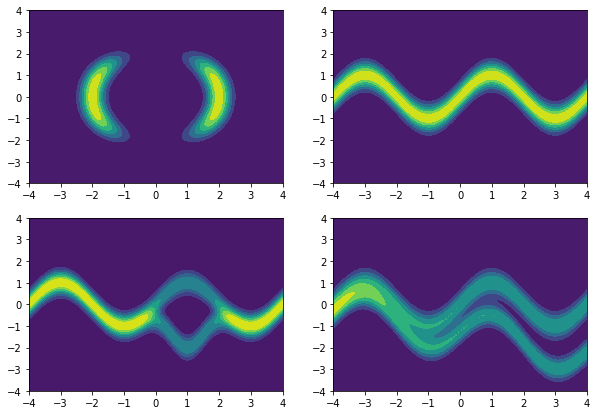

In [5]:
xline = np.linspace(-4, 4, 100)
yline = np.linspace(-4, 4, 100)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

zz = np.exp(-U1(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid1 = zz.reshape(100,100)

zz = np.exp(-U2(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid2 = zz.reshape(100,100)

zz = np.exp(-U3(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid3 = zz.reshape(100,100)

zz = np.exp(-U4(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid4 = zz.reshape(100,100)

fig,ax = plt.subplots(2,2,figsize=(10,7))

ax[0,0].contourf(xgrid, ygrid, zgrid1)
ax[0,1].contourf(xgrid, ygrid, zgrid2)
ax[1,0].contourf(xgrid, ygrid, zgrid3)
ax[1,1].contourf(xgrid, ygrid, zgrid4)
plt.show()

In [6]:
def kl_reverse(z,x,log_det,true_density):
    log_pz = base_distr.log_prob(z)
    log_pX = torch.log(torch.clamp(true_density(x),min=1e-20)) ## only need unnormalized density
    return torch.mean(log_pz-log_det-log_pX,dim=0)

In [7]:
def train_shapes(model,n_batch=500,n_epochs=10001,U=U1p):
    true_density = lambda x : torch.exp(-U(x))

    train_loss = []

    for i in range(n_epochs):
        if i%100==0:
            print(i)

        model.train()

        z0 = torch.randn(n_batch,2,device=device)
        xs,log_det = model(z0)

        # print(log_det.mean(),xs[-1])

        loss = kl_reverse(z0,xs[-1],log_det,true_density)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(loss.item())
        if i%100==0:
            print(loss)

    return train_loss

In [8]:
base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
    torch.zeros(2,device=device),torch.eye(2,device=device))

### $U_1$

In [9]:
sylvesterFlows = []
for k in range(32):
    sylvesterFlows.append(TriangularSylvesterFlow(2,k%2))

model = NormalizingFlows(sylvesterFlows)

model = model.to(device)

# optimizer = optim.RMSprop(model.parameters(),lr=1e-5,momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  448


In [10]:
train_loss = train_shapes(model,U=U1p,n_epochs=2001)

0
tensor(43.6373, device='cuda:0', grad_fn=<MeanBackward1>)
100
tensor(-16.3319, device='cuda:0', grad_fn=<MeanBackward1>)
200
tensor(-38.4238, device='cuda:0', grad_fn=<MeanBackward1>)
300
tensor(-51.1935, device='cuda:0', grad_fn=<MeanBackward1>)
400
tensor(-65.0090, device='cuda:0', grad_fn=<MeanBackward1>)
500
tensor(-80.4052, device='cuda:0', grad_fn=<MeanBackward1>)
600
tensor(-92.6796, device='cuda:0', grad_fn=<MeanBackward1>)
700
tensor(-106.6213, device='cuda:0', grad_fn=<MeanBackward1>)
800
tensor(-116.0662, device='cuda:0', grad_fn=<MeanBackward1>)
900
tensor(-123.2033, device='cuda:0', grad_fn=<MeanBackward1>)
1000
tensor(-129.9012, device='cuda:0', grad_fn=<MeanBackward1>)
1100
tensor(-135.0132, device='cuda:0', grad_fn=<MeanBackward1>)
1200
tensor(-141.2496, device='cuda:0', grad_fn=<MeanBackward1>)
1300
tensor(-146.0636, device='cuda:0', grad_fn=<MeanBackward1>)
1400
tensor(-150.7272, device='cuda:0', grad_fn=<MeanBackward1>)
1500
tensor(-137.5436, device='cuda:0', grad_

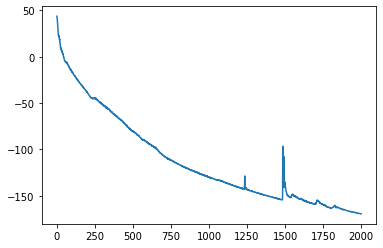

In [11]:
plt.plot(train_loss)
plt.show()

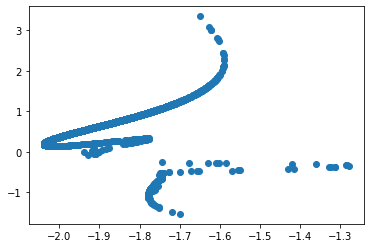

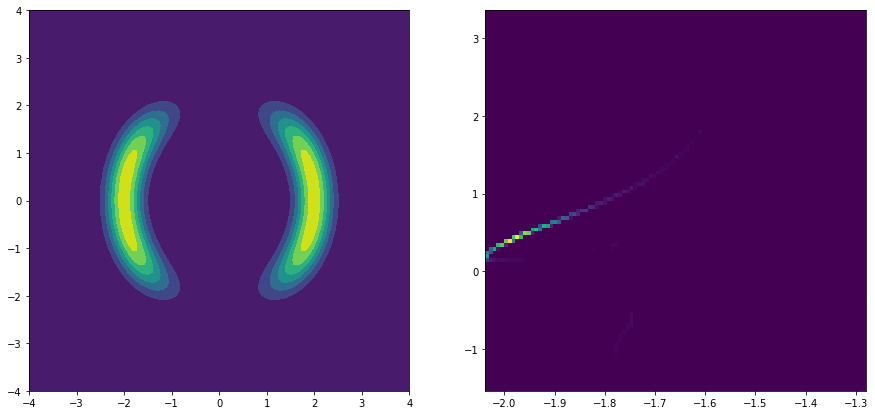

In [12]:
z,_ = model(torch.randn(10000,2,device=device))
samples = z[-1].detach().cpu().numpy()

plt.scatter(samples[:,0],samples[:,1])
plt.show()

fig,ax = plt.subplots(1,2,figsize=(15,7))

ax[0].contourf(xgrid, ygrid, zgrid1)
ax[1].hist2d(samples[:,0],samples[:,1],bins=100)
plt.show()

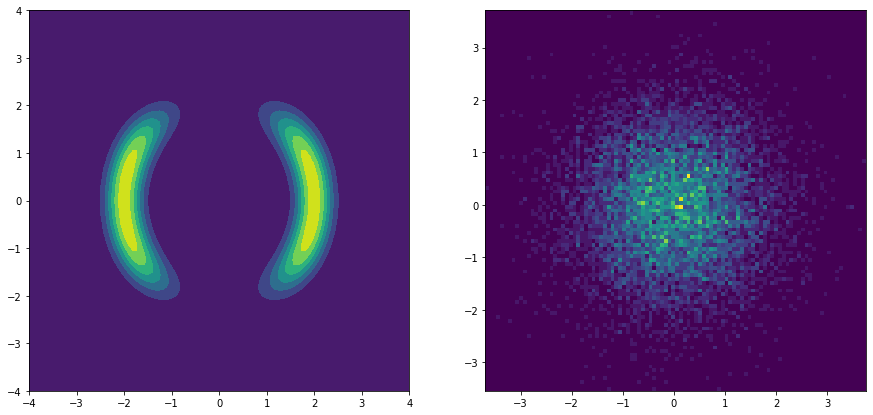

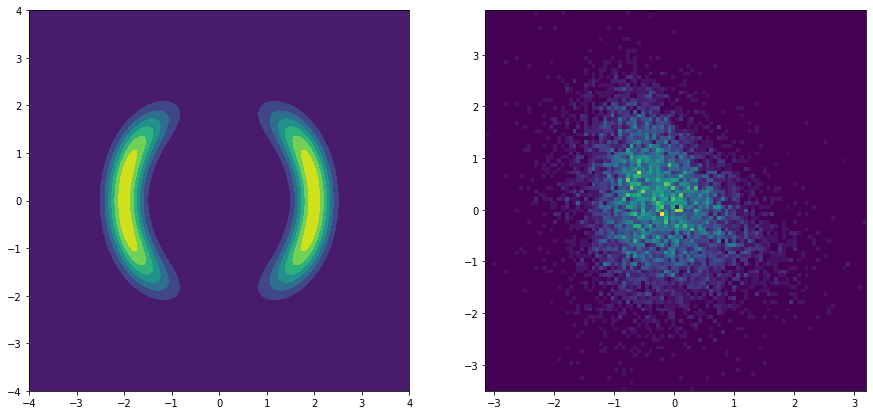

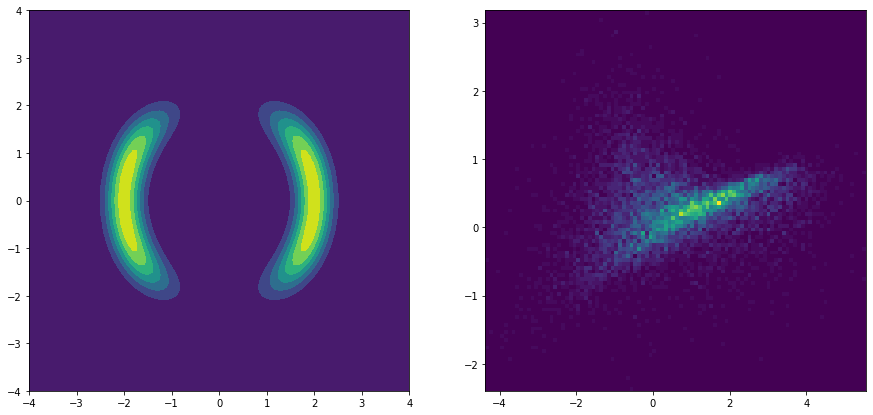

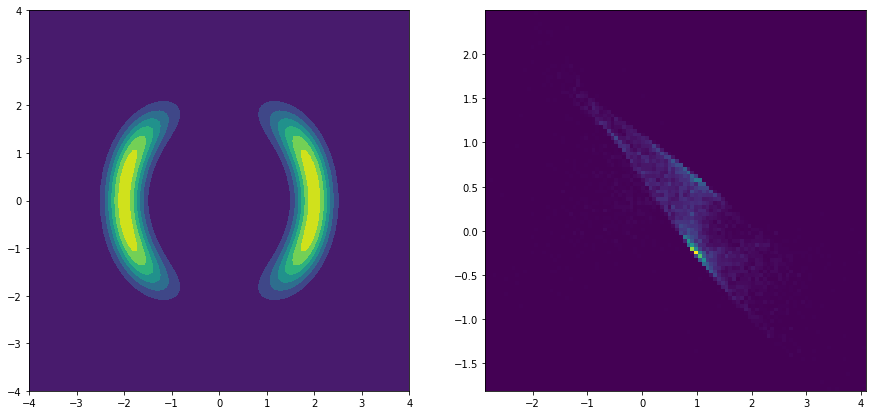

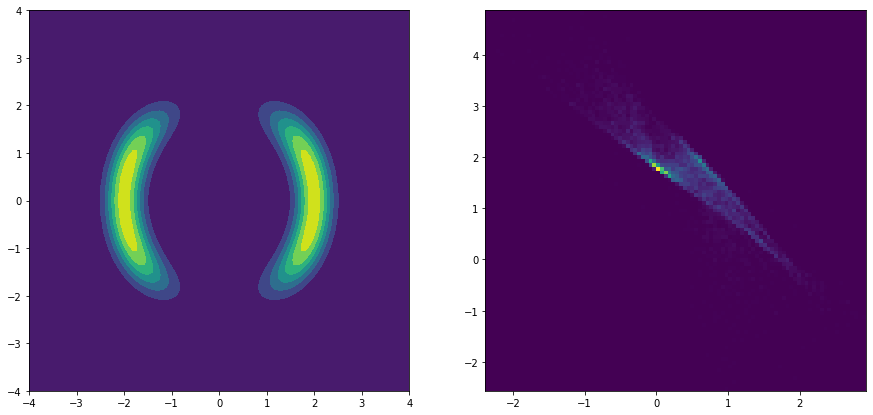

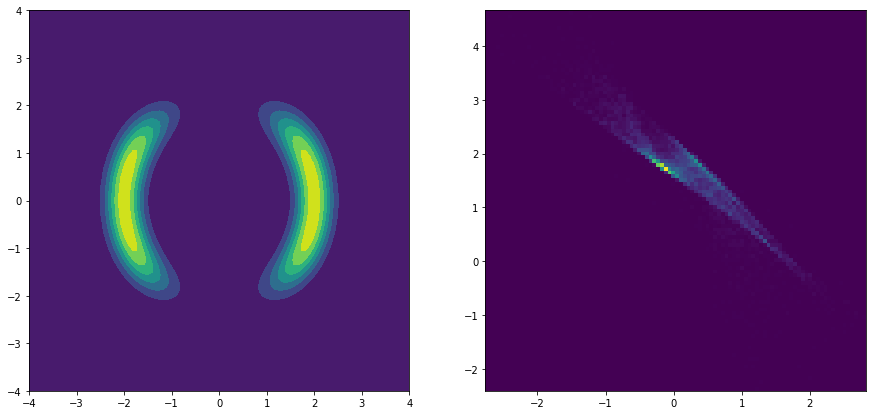

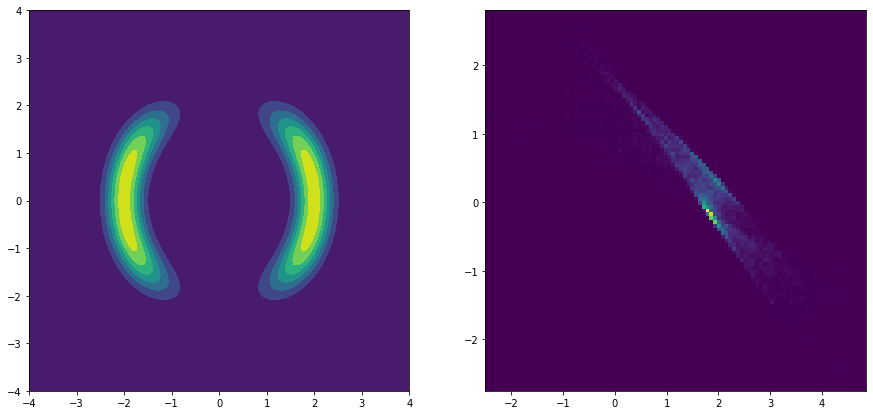

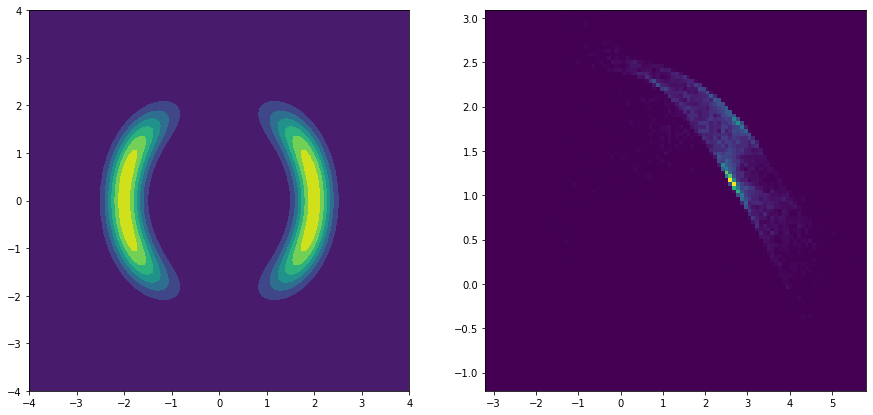

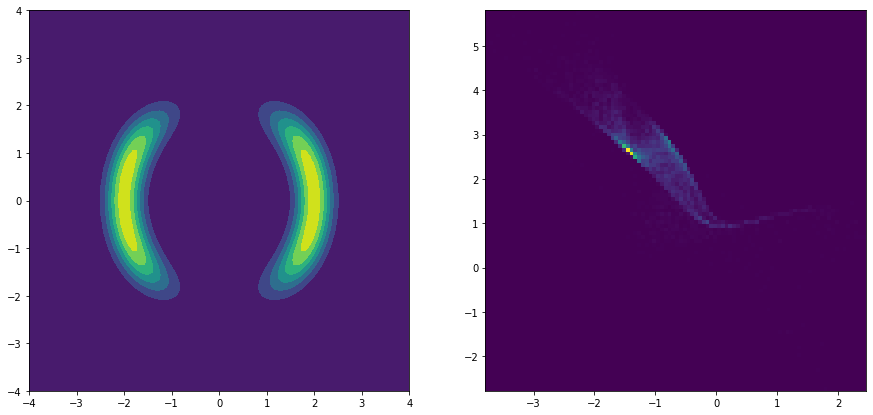

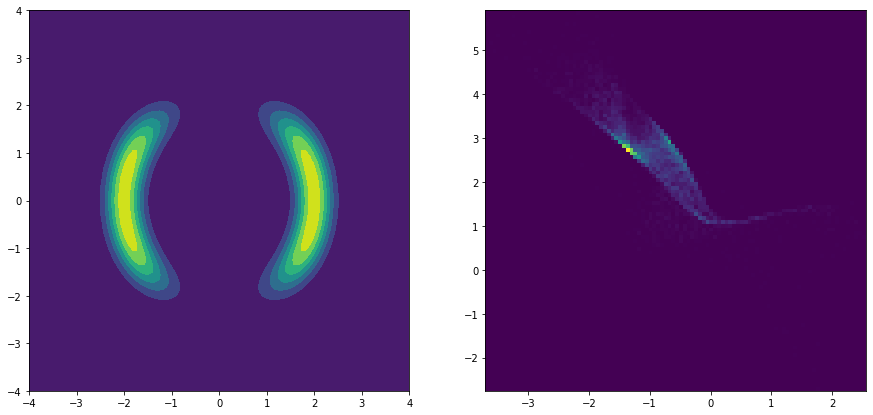

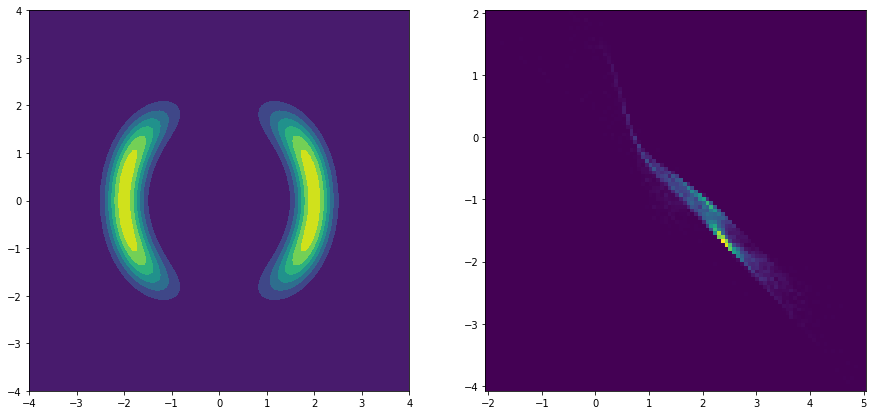

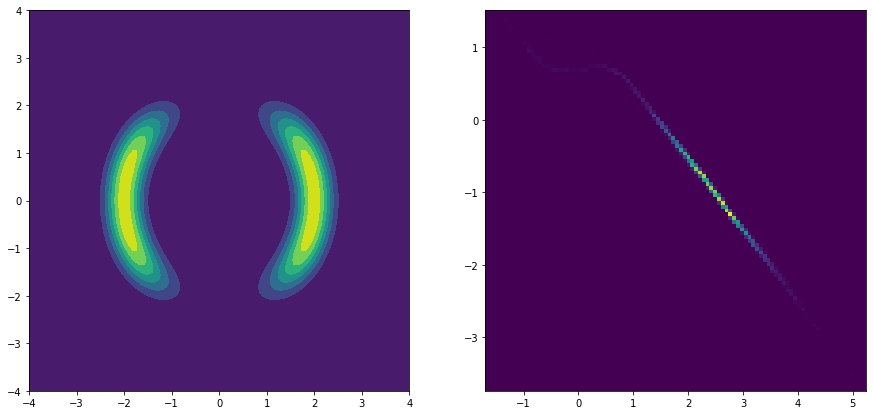

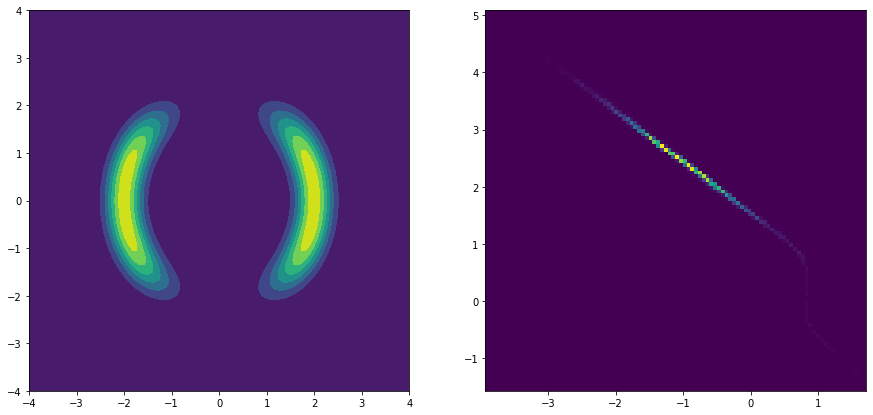

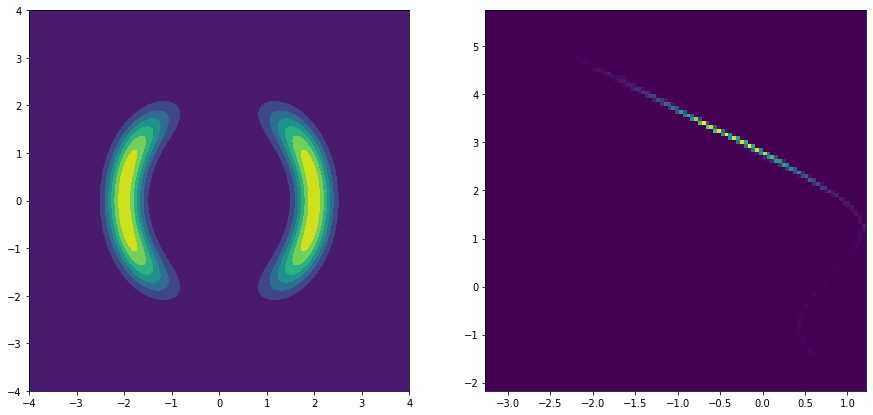

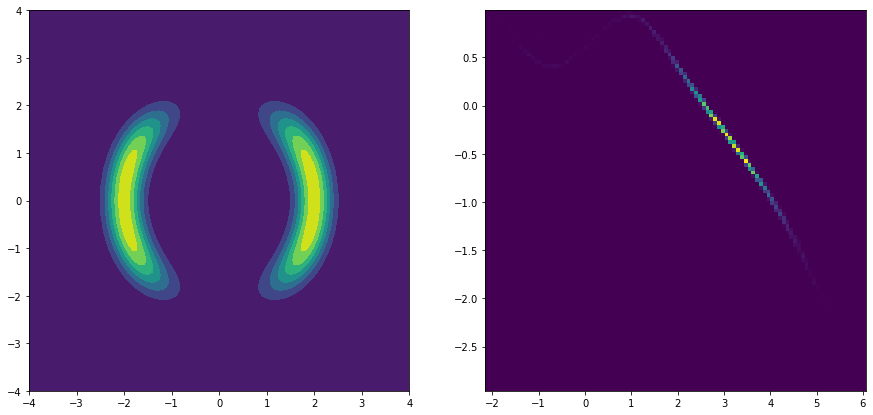

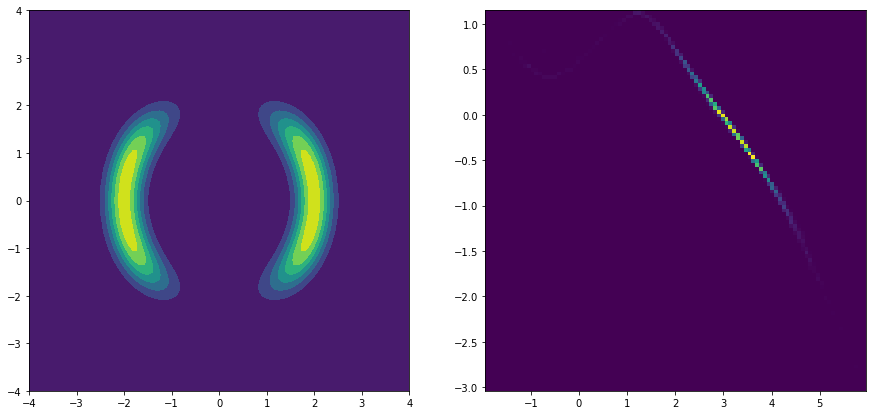

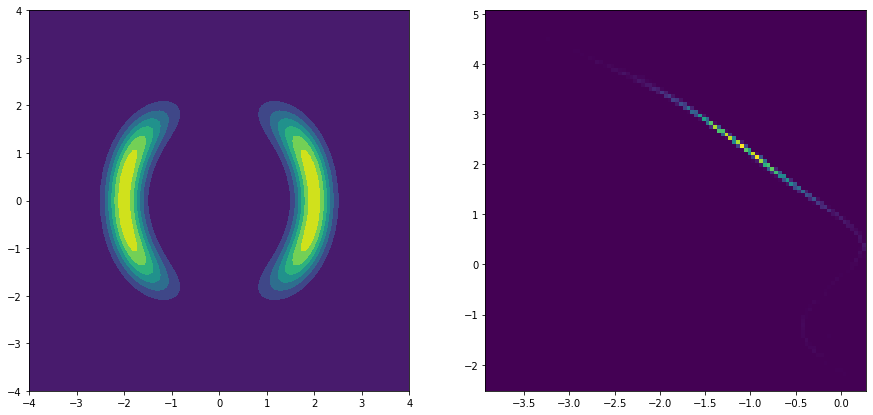

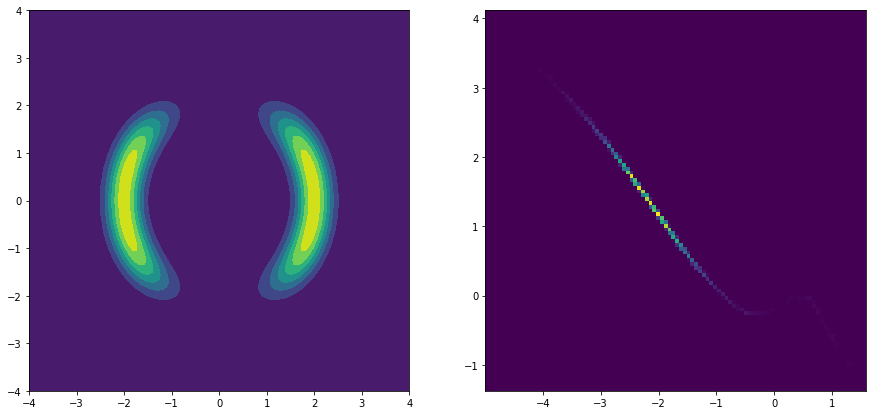

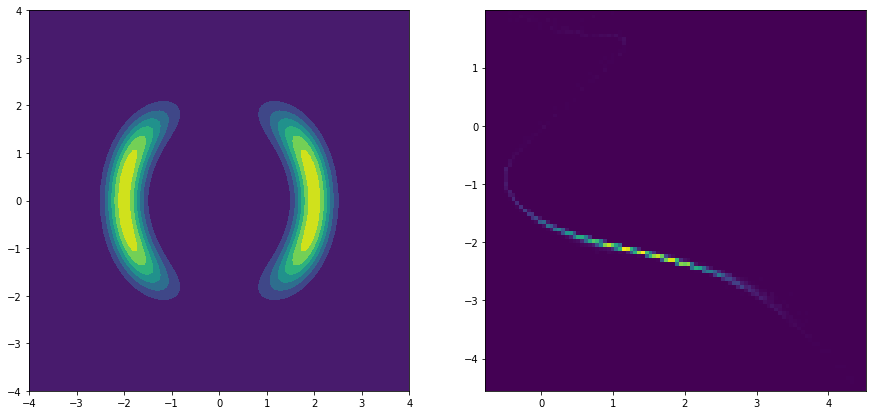

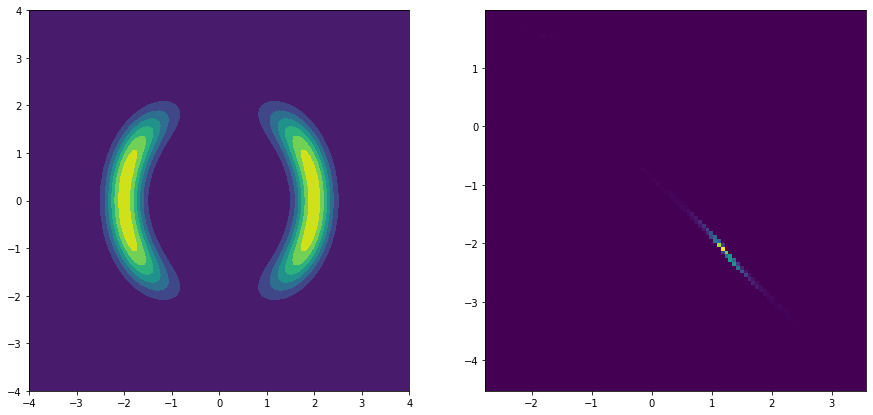

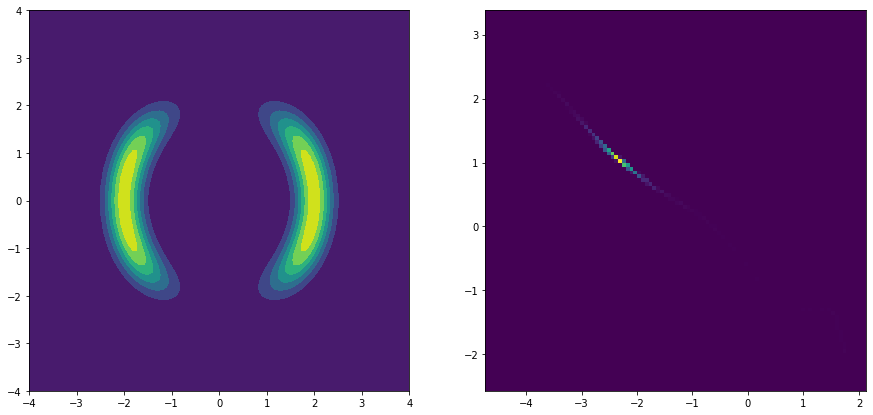

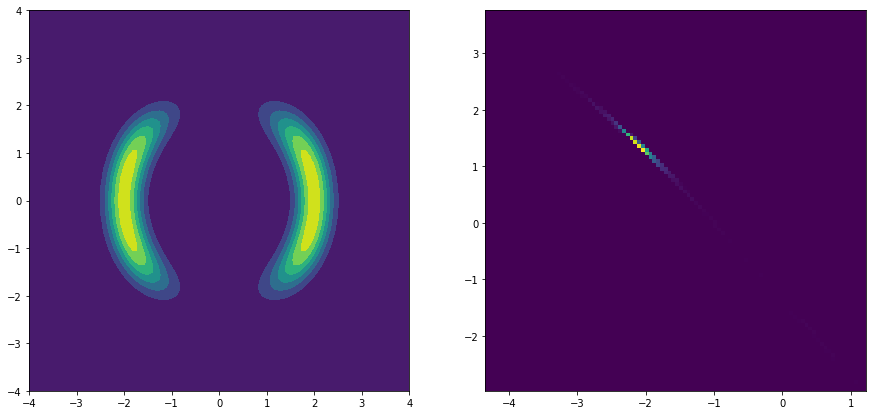

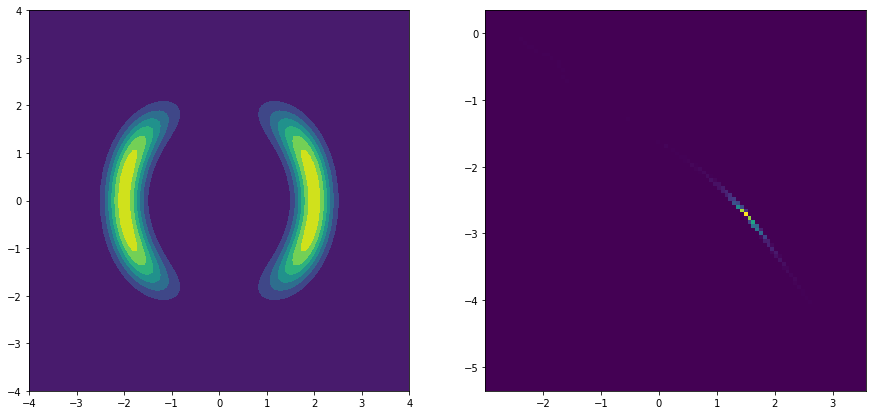

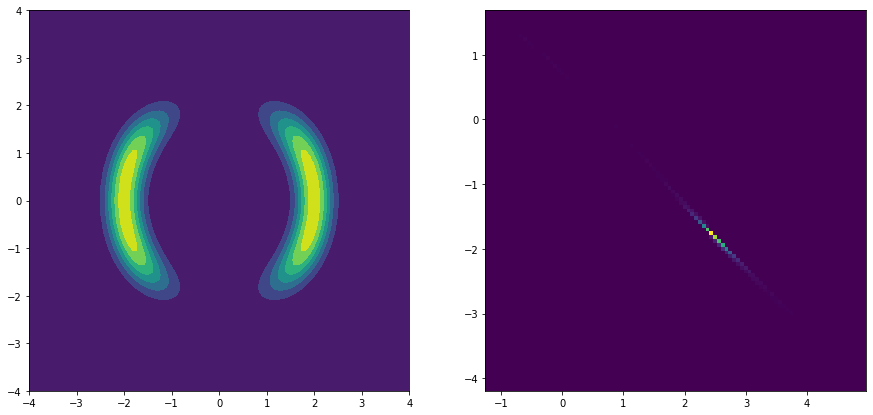

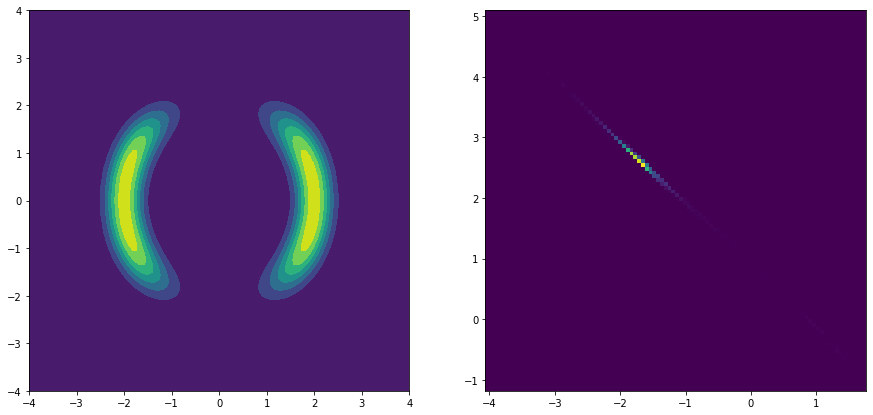

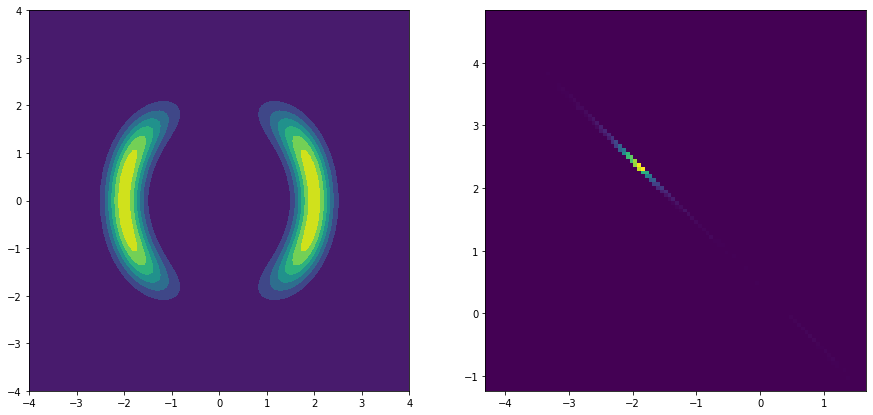

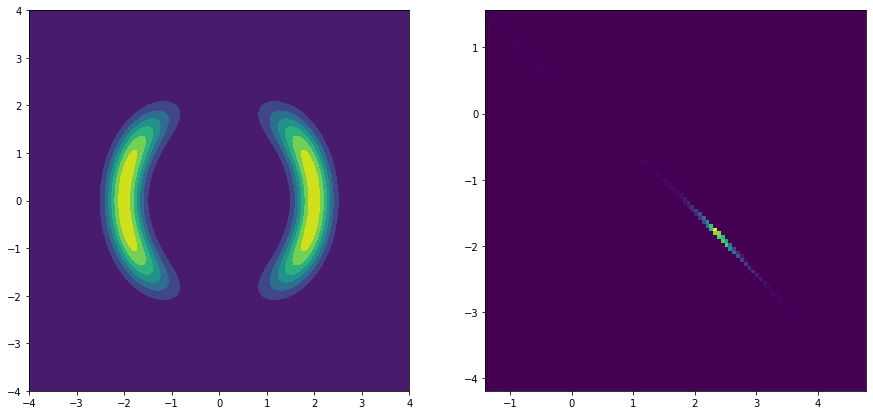

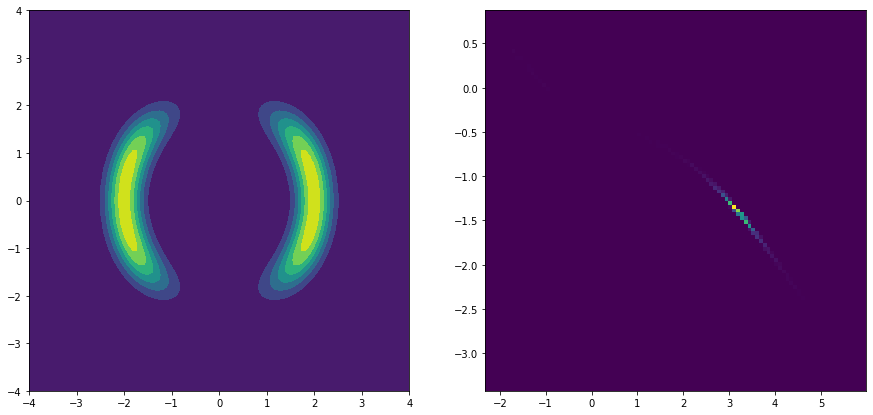

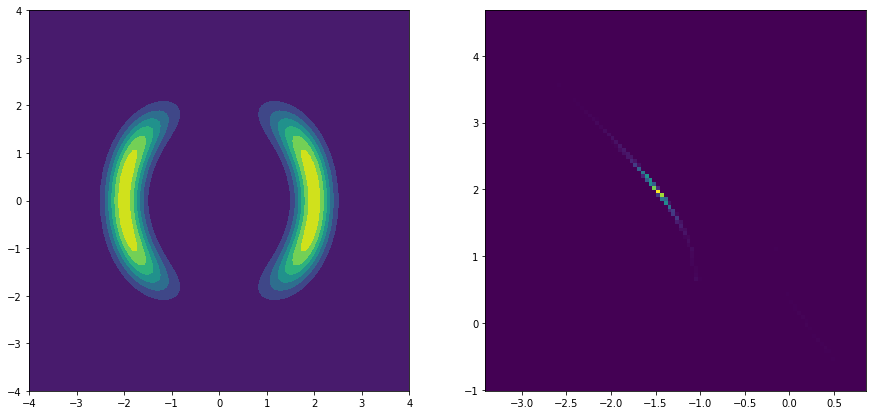

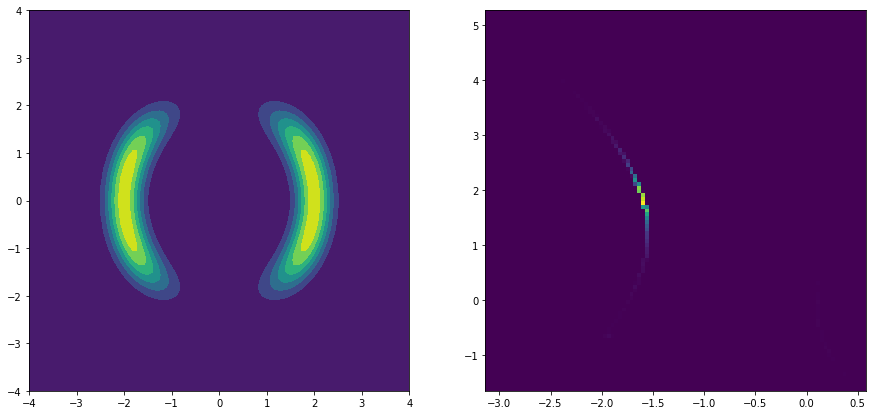

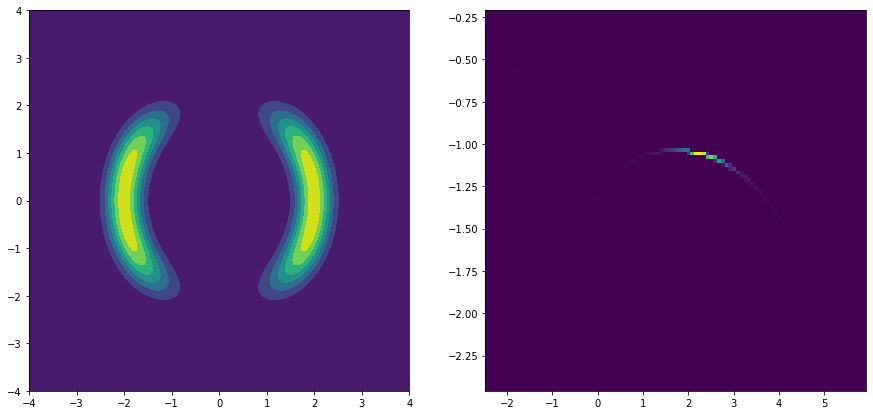

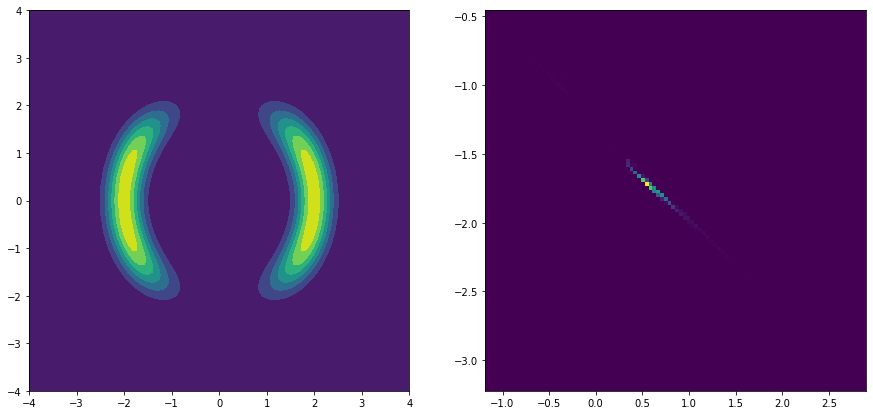

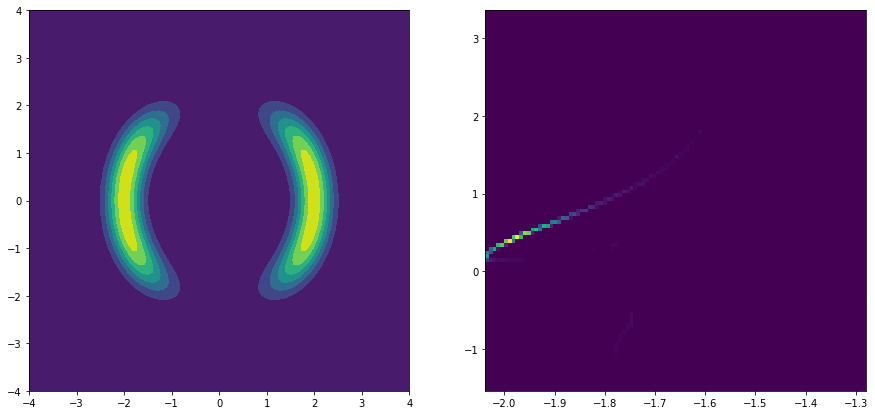

In [13]:
for i in range(len(z)):
    sample = z[i].detach().cpu().numpy()
    fig,ax = plt.subplots(1,2,figsize=(15,7))

    ax[0].contourf(xgrid, ygrid, zgrid1)
    ax[1].hist2d(sample[:,0],sample[:,1],bins=100)
    plt.show()

In [14]:
print(

SyntaxError: ignored

### $U_2$

In [ ]:
sylvesterFlows = [TriangularSylvesterFlow(2) for k in range(32)]
model = NormalizingFlows(sylvesterFlows)

model = model.to(device)

# optimizer = optim.RMSprop(model.parameters(),lr=1e-5,momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [ ]:
train_loss = train_shapes(model,U=U2p)

In [ ]:
plt.plot(train_loss)
plt.show()

In [ ]:
samples,_ = model(torch.randn(10000,2,device=device))
samples = samples[-1].detach().cpu().numpy()

plt.scatter(samples[:,0],samples[:,1])
plt.show()

fig,ax = plt.subplots(1,2,figsize=(15,7))

ax[0].contourf(xgrid, ygrid, zgrid2)
ax[1].hist2d(samples[:,0],samples[:,1],bins=100)
ax[1].set_xlim(-4,4)
plt.show()

## Variational Encoder with NF

ELBO:
We have:
\begin{align*}
    \log p_\theta(x)&\geq \log p_\theta(x)-KL(q(\cdot|x)||p_\theta(\cdot|x))\\
    &= \int \log(\frac{p_\theta(x,z)}{q(z|x)})q(z|x)dz \\
    &= \mathbb{E}_{q(\cdot|x)}[p_\theta(x|z)]-KL(q(\cdot|x)||p_\theta) \\
    &= -\mathcal{F}(\theta)
\end{align*}

**Variational Encoder**:
- encoder: $q_\phi(z|x)$
- decoder: $p_\theta(x|z)$

Example for classical VAE:
- encoder: $q_\phi(z|x)=\mathcal{N}(z;\mu,\sigma^2 I)$
- apriori: $p_\theta(z)=\mathcal{N}(z;0,I)$
- decoder: $p_\theta(x|z)=\mathcal{N}(x;\mu(z),\sigma^2(z))$ or $p_\theta(x|z)=\text{Ber}(D(z))$

**VAE with NF**: 

Idea: improve the class of distribution for the variational inference with a normalizing flow in the latent space (e.g. not just a mean field approximation with gaussians anymore).

- $q_0(z|x)=\mathcal{N}(z;\mu(x),\sigma^2(x))$

Let $z_0\sim q_0(\cdot|x)$,

- $z_K = f_K\circ\dots\circ f_1(z_0) = f(z_0)$
- $q_K(z_K|x) = q_0(z_0|x)|\det J_f(f^{-1}(z_K))|^{-1}$
- $\log q_K(z_K|x) = \log q_0(z_0|x) - \sum_{k=1}^K \log |\det \frac{\partial f_k}{\partial z_{k-1}}(z_{k-1})|$

Then, denoting $q_\phi=q_K$, the ELBO transforms as:

\begin{align*}
    \mathcal{F}(\theta,\phi) &= \mathbb{E}_{q_\phi}[\log q_\phi(z|x)-\log p_\theta(x,z)] \\
    &= \mathbb{E}_{q_0}[\log q_0(z_0|x)-\log p_\theta(x,f(z_0))-\sum_{k=1}^K \log |\det \frac{\partial f_k}{\partial z_{k-1}}(z_{k-1})|]
\end{align*}

In [ ]:
def uniform_quantization(img):
    return (img*255+torch.rand(img.size()))/256

def rescale_logit(img,lambd=1e-6):
    ## logit space
    return torch.logit(lambd+(1-2*lambd)*img)

In [ ]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()#,
#                 uniform_quantization,
#                 rescale_logit
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

In [ ]:
plt.imshow(train_dataset[0][0].reshape(28,28),"gray")
plt.show()

In [ ]:
class Encoder(nn.Module):
    def __init__(self, d=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(28*28,512)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dense_mean = nn.Linear(512,d)
        self.dense_log_var = nn.Linear(512,d)
        
    def forward(self, x):
        z = self.flatten(x)
        z = self.dense(z)
        z = self.leaky_relu(z)
        z_mean = self.dense_mean(z)
        z_log_var = self.dense_log_var(z)
        return z_mean, z_log_var


class Decoder(nn.Module):
    def __init__(self,d=10):
        super().__init__()
        self.dense = nn.Linear(d,512)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dense2 = nn.Linear(512,28*28)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.dense(x)
        x = self.leaky_relu(x)
        x = self.dense2(x)
        x = self.sigmoid(x)
        return x.view(-1,28,28)
    
    
class VAE(nn.Module):
    def __init__(self,flow,d=10):
        super().__init__()
        self.encoder = Encoder(d)
        self.decoder = Decoder(d)
        self.flow = flow
    
    def forward(self, x):
        mu, log_sigma = self.encoder(x)        
        z0 = mu+torch.randn(mu.shape, device=device)*torch.exp(log_sigma)
        zKs, log_det = self.flow(z0)
        y = self.decoder(zKs[-1])
        return y, mu, log_sigma, log_det

In [ ]:
criterion = nn.BCELoss(reduction='sum')

def vae_loss(x, y, mu, log_sigma, log_det):    
    reconstruction_loss = criterion(y, x)
    kl_loss = -0.5*torch.sum(mu.pow(2)+log_sigma.exp()-log_sigma-1)
    
    return reconstruction_loss-kl_loss-log_det.sum()

In [ ]:
sylvesterFlows = [TriangularSylvesterFlow(10) for k in range(2)]
flow = NormalizingFlows(sylvesterFlows)

model = VAE(flow, d=10).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
print("number of params: ", sum(p.numel() for p in model.parameters()))

In [ ]:
n_epochs = 201

losses = []
val_losses = []

for e in range(n_epochs):   
    loss_epoch = 0
    cpt_batch = 0
    
    for x_batch, _ in train_loader:
        x_batch = x_batch.to(device)
        
        model.train()
        
        yhat, mu, log_sigma, log_det = model(x_batch.reshape(-1,28,28))
        yhat = yhat.reshape(-1,1,28,28)
        
        l = vae_loss(x_batch, yhat, mu, log_sigma, log_det)
        
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_epoch += l.item()/x_batch.size(0) ## Mean
        cpt_batch += 1
        
    losses.append(loss_epoch/cpt_batch)
    
    loss_val_epoch = 0
    cpt_batch = 0
        
    with torch.no_grad():
        for x_val, _ in test_loader:
            x_val = x_val.to(device)
            
            model.eval()
            yhat, mu, log_sigma, log_det = model(x_val.reshape(-1,28,28))
            yhat = yhat.reshape(-1,1,28,28)
            
            val_l = vae_loss(x_val,yhat,mu,log_sigma,log_det)
            loss_val_epoch += val_l.item()/x_val.size(0)
            cpt_batch += 1
            
        val_losses.append(loss_val_epoch/cpt_batch)
    
    print(e,losses[-1],val_losses[-1])
        
    if e%50 == 0:  
        for x_val, _ in test_loader:
            fig,ax = plt.subplots(1,2,figsize=(10,10))

            ax[0].imshow(x_val[0][0],"gray")

            x_val = x_val.to(device)

            model.eval()
            yhat, mu, sigma, log_det = model(x_val[0][0].reshape(-1,28,28))
            yhat = yhat.reshape(-1,1,28,28)
            ax[1].imshow(yhat[0][0].cpu().detach().numpy(),"gray")
            plt.show()
            break
        

In [ ]:
plt.plot(losses,label="loss")
plt.plot(val_losses,label="val loss")
plt.legend()
plt.show()

To do:
- Log Likelihood estimation

## References

<a id="reference1"></a>

[1] Berg, R., Hasenclever, L., Tomczak, M. J., & Welling, M. Sylvester Normalizing Flows for Variational Inference. arXiv preprint arXiv:1803.05649. (2018). [link](https://arxiv.org/pdf/1803.05649)